In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline




In [2]:
# Reading and transforming the file
cities = pd.read_csv('C:/Users/div21/Downloads/ClimateChange.csv')
gtemp = cities[cities['City'].isin (['Saint Petersburg'])]
gtemp =gtemp[['dt','AverageTemperature','City']]
gtemp.columns = ['Date','Temp','City']
gtemp['Date'] = pd.to_datetime(gtemp['Date'])
gtemp.reset_index(drop=True, inplace=True)
gtemp.set_index('Date', inplace=True)

#I'm going to consider the temperature just from 1900 until the end of 2013


gtemp.head()
            


,Temp,City
Date,,
1900-01-01,-8.352,Saint Petersburg
1900-02-01,-9.852,Saint Petersburg
1900-03-01,-5.502,Saint Petersburg
1900-04-01,0.463,Saint Petersburg
1900-05-01,6.449,Saint Petersburg


In [3]:
import statsmodels.api as sm
import itertools

No handles with labels found to put in legend.


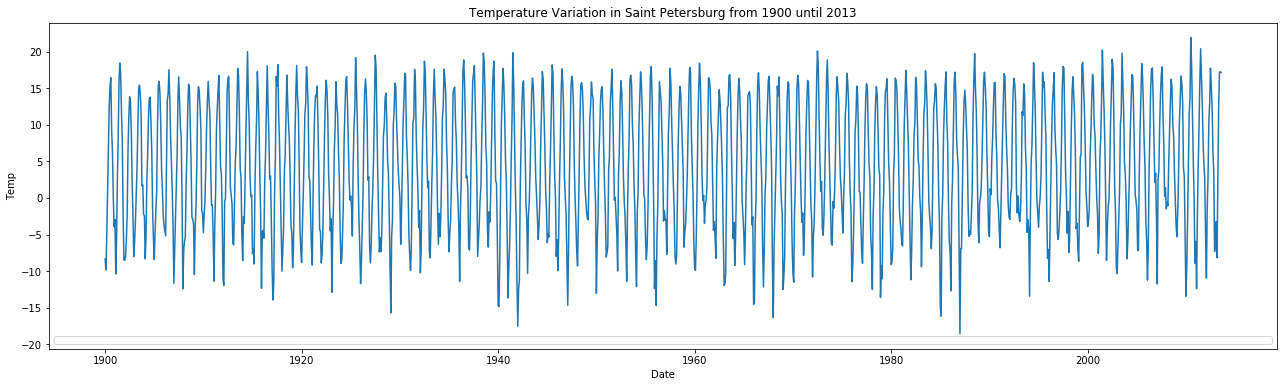

In [4]:
plt.figure(figsize=(22,6))
sns.lineplot(x=gtemp.index, y=gtemp['Temp'])
plt.title('Temperature Variation in Saint Petersburg from 1900 until 2013')
plt.legend(loc ="lower left" , mode='expand',ncol=len(gtemp.columns))
plt.show()

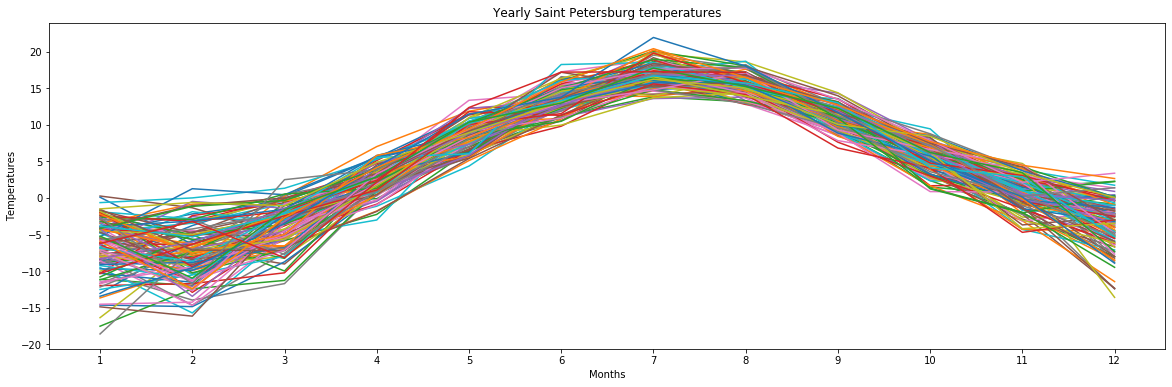

In [5]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
gtemp['month'] = gtemp.index.month
gtemp['year'] = gtemp.index.year
pivot = pd.pivot_table(gtemp, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly Saint Petersburg temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

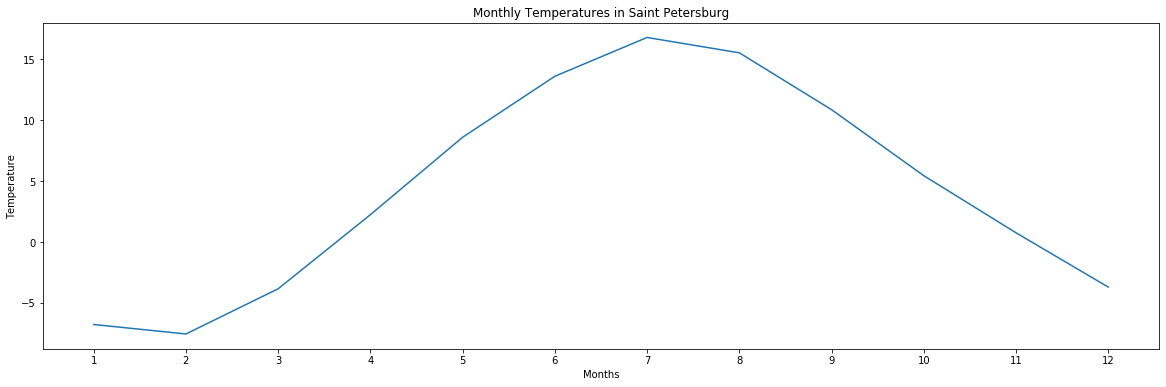

In [6]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Temperatures in Saint Petersburg')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

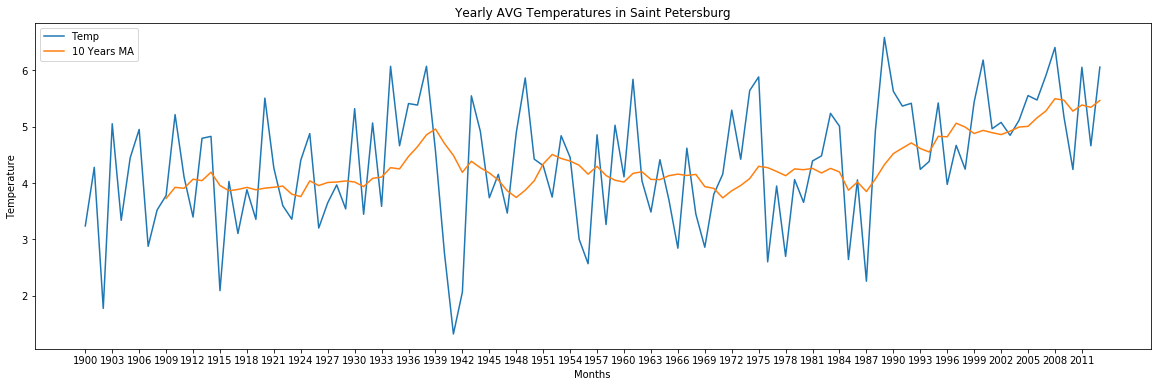

In [7]:
year_avg = pd.pivot_table(gtemp, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Temperatures in Saint Petersburg')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1900,2013,3)])
plt.show()

In [8]:
train = gtemp[:-60].copy()
val = gtemp[-60:-12].copy()
test = gtemp[-12:].copy()
print(f'Training set: {train.count()} ,validation set : {val.count()}, Testing set : {test.count()}')

Training set: Temp     1305
City     1305
month    1305
year     1305
dtype: int64 ,validation set : Temp     48
City     48
month    48
year     48
dtype: int64, Testing set : Temp     11
City     12
month    12
year     12
dtype: int64


In [12]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 5.6076 celsius degrees


In [11]:
# Excluding the first line, as it has NaN values
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-11-01    8.432
2008-12-01    3.424
2009-01-01    0.067
2009-02-01   -3.850
2009-03-01   -5.310
Name: Temp, dtype: float64

In [13]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Uk and Russia Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -5.3957
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1281.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


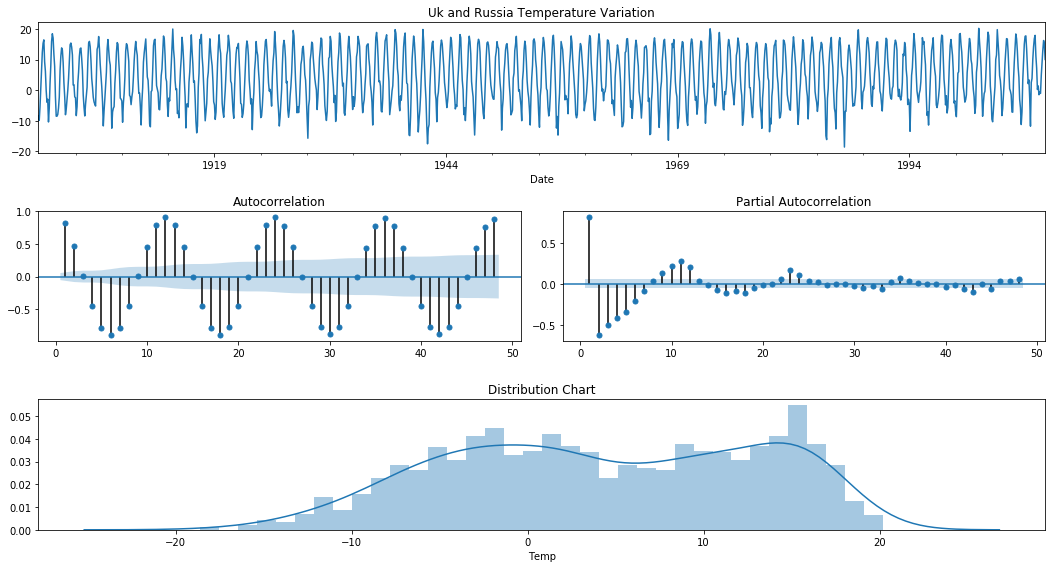

In [14]:
check_stationarity(train['Temp'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -12.1029
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1269.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


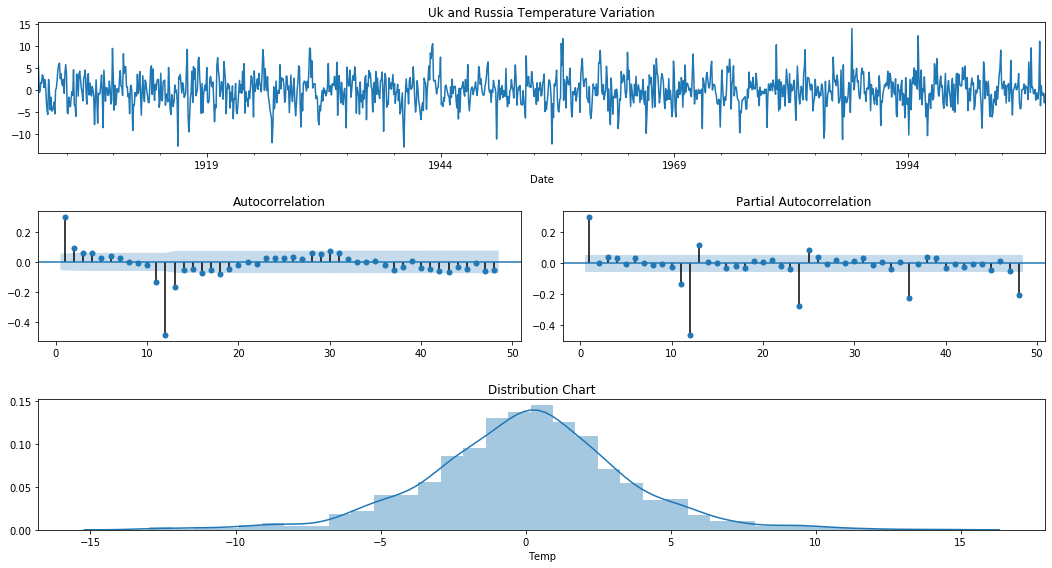

In [15]:
check_stationarity(train['Temp'].diff(12).dropna())

In [16]:
# Excluding the first line, as it has NaN values
train['Temp'].dropna(inplace=True)
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-11-01    8.432
2008-12-01    3.424
2009-01-01    0.067
2009-02-01   -3.850
2009-03-01   -5.310
Name: Temp, dtype: float64

In [17]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['Temp'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:20049.92717250891
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:17515.84974486111
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13163.2500564536
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12297.071361505401
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13114.952519470324
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12342.763843702793
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12555.396911161226
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12298.157044918102
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:17398.084127970356
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:15786.913021616907
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:12911.666293596261
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11887.39492006458
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12842.724561806961
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11932.684637370417
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12253.955351298298
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11889.139719804776
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:15321.3670129935
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:14373.242175045863

In [18]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((1,1,1),(0,1,1,12),'c'))

In [19]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(1,0,1),(1,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(1,0,1),(1,1,1,12),'c' model was 2.3596 celsius degrees
It's a decrease of -57.92% in the RMSE


In [20]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']

In [133]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [149]:
# We need to remove some columns to plot the charts
new = val.drop(columns=['City'])
new.head()


,Temp,Pred,Error
Date,,,
2008-10-01,8.432,5.858499,2.573501
2008-11-01,3.424,2.289048,1.134952
2008-12-01,0.067,-2.112339,2.179339
2009-01-01,-3.850,-4.729355,0.879355
2009-02-01,-5.310,-5.862329,0.552329


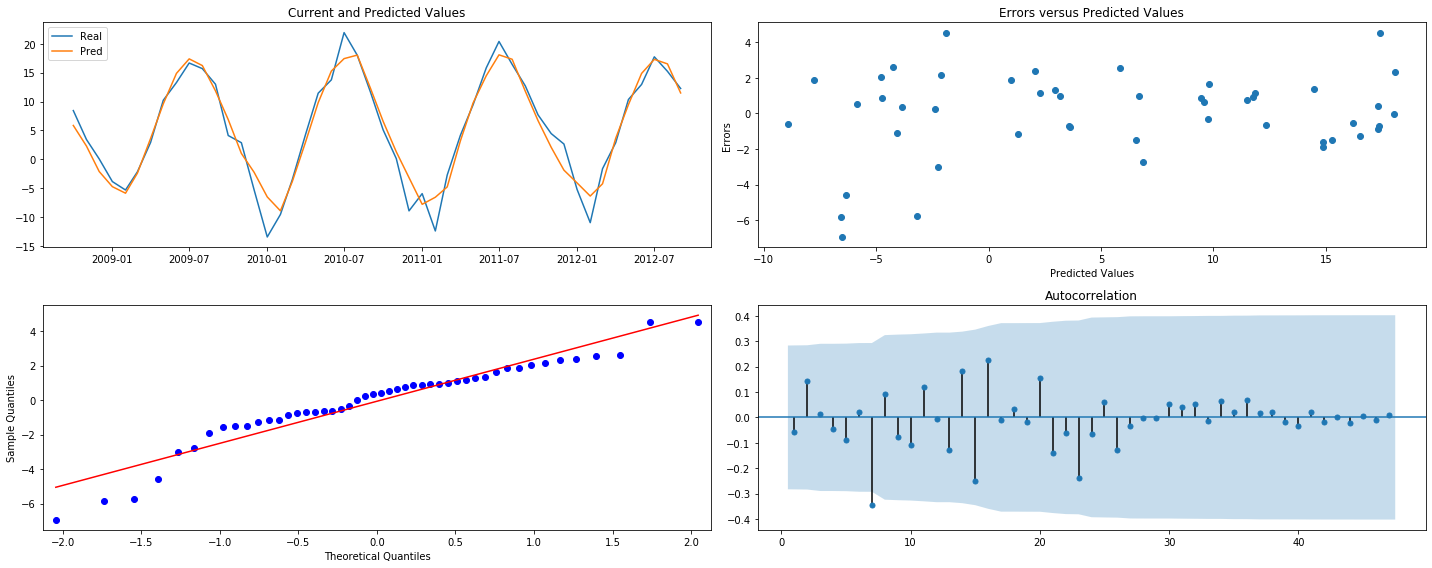

In [151]:
plot_error(new)

In [36]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-01   -8.352
1900-02-01   -9.852
1900-03-01   -5.502
1900-04-01    0.463
1900-05-01    6.449
Name: Temp, dtype: float64

In [37]:
sm.stats.acorr_ljungbox(val['Error'], lags=[12],boxpierce=True)

(array([11.41656537]),
 array([0.49359599]),
 array([9.37261457]),
 array([0.67081763]))

In [38]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(1,0,1), seasonal_order=(1,1,1,12), trend='c')
result = model.fit(disp=False)

In [39]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+12))
test.head()

,Temp,City,month,year,Pred
Date,,,,,
2012-10-01,6.208,Saint Petersburg,10,2012,6.330687
2012-11-01,3.448,Saint Petersburg,11,2012,1.575934
2012-12-01,-7.316,Saint Petersburg,12,2012,-2.755935
2013-01-01,-6.218,Saint Petersburg,1,2013,-6.086363
2013-02-01,-3.228,Saint Petersburg,2,2013,-7.126335


In [96]:
predict = test['Pred']
predict.head(20)

Date
2012-10-01     6.330687
2012-11-01     1.575934
2012-12-01    -2.755935
2013-01-01    -6.086363
2013-02-01    -7.126335
2013-03-01    -3.094601
2013-04-01     2.882825
2013-05-01     9.257200
2013-06-01    14.160138
2013-07-01    17.444664
2013-08-01    16.119417
2013-09-01    11.540343
Name: Pred, dtype: float64

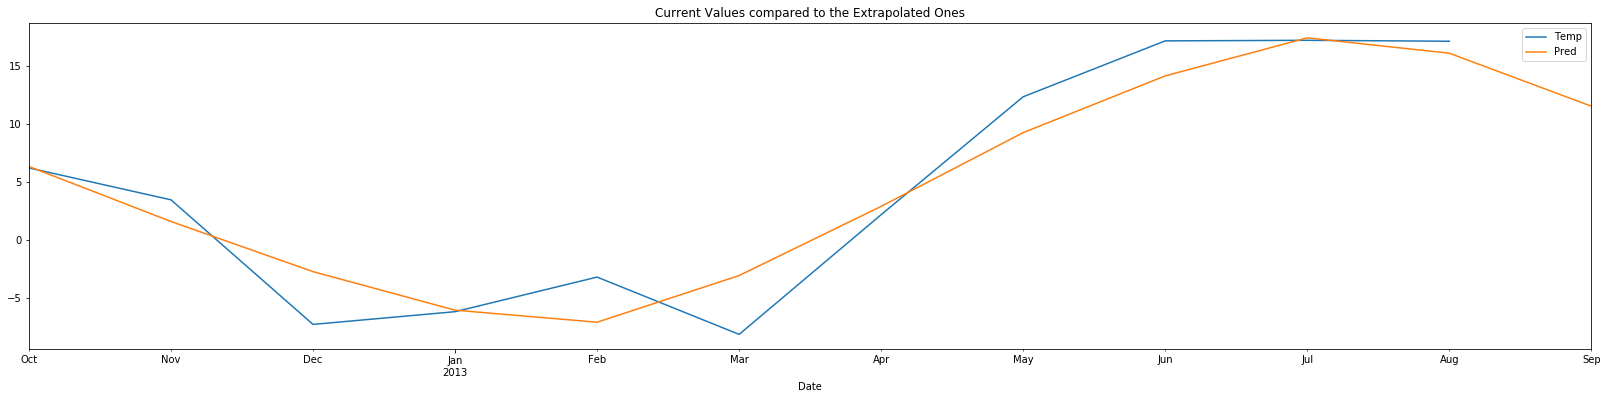

In [48]:
test[['Temp', 'Pred']].plot(figsize=(28,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

In [126]:
test_baseline = test['Temp'].shift()
test_baseline[0] = test['Temp'][0]

final =test_baseline.drop(test_baseline.index[11])
final.head(13)



Date
2012-10-01     6.208
2012-11-01     6.208
2012-12-01     3.448
2013-01-01    -7.316
2013-02-01    -6.218
2013-03-01    -3.228
2013-04-01    -8.178
2013-05-01     2.167
2013-06-01    12.355
2013-07-01    17.185
2013-08-01    17.234
Name: Temp, dtype: float64

In [109]:

plate= test['Temp'].dropna()
plate.head(120)

Date
2012-10-01     6.208
2012-11-01     3.448
2012-12-01    -7.316
2013-01-01    -6.218
2013-02-01    -3.228
2013-03-01    -8.178
2013-04-01     2.167
2013-05-01    12.355
2013-06-01    17.185
2013-07-01    17.234
2013-08-01    17.153
Name: Temp, dtype: float64

In [127]:


rmse_test_base = measure_rmse(plate,final)


print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')


The baseline RMSE for the test baseline was 5.97 celsius degrees


In [129]:
Pred =test['Pred'].drop(test['Pred'].index[11])
Pred.head(13)

Date
2012-10-01     6.330687
2012-11-01     1.575934
2012-12-01    -2.755935
2013-01-01    -6.086363
2013-02-01    -7.126335
2013-03-01    -3.094601
2013-04-01     2.882825
2013-05-01     9.257200
2013-06-01    14.160138
2013-07-01    17.444664
2013-08-01    16.119417
Name: Pred, dtype: float64

In [131]:
rmse_test_extrap = measure_rmse(plate, Pred)
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test extrapolation was 2.79 celsius degrees
That is an improvement of 53.25%
